_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [170]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [172]:
'''T1. Import DataFrame `df`'''

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'

In [173]:
# def wrangle(url):
#   df = pd.read_csv(url,
#                     parse_dates=['game_date'],
#                     index_col='game_id').sort_index()


#   # Drop constant columns
#   df.drop(columns=['player_name'], inplace=True)

#   # Create age feature
#   df['time_remaining'] = (df['minutes_remaining']*60) + df['seconds_remaining']
#   df.drop(columns=['minutes_remaining', 'seconds_remaining'], inplace=True)

#   # Drop HCCCs
#   cutoff = 100
#   drop_cols = [col for col in df.select_dtypes('object').columns
#               if df[col].nunique() > cutoff]
#   df.drop(columns=drop_cols, inplace=True)

#   # Drop duplicate columns # check for atleast a 100 values
#   dupe_cols = [col for col in df.head(100).T.duplicated().index
#                if df.head(100).T.duplicated()[col]]
#   df.drop(columns=dupe_cols, inplace=True)             

#   return df

# df = wrangle(url)

In [201]:
df = pd.read_csv(url, parse_dates=['game_date'], index_col='game_date').sort_index()

**Task 1 Testing**

In [178]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'

**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [203]:
df['time_remaining'] = (df['minutes_remaining']*60) + df['seconds_remaining']

In [204]:
"""T2. Create new feature"""

# df['time_remaining'] = (df['minutes_remaining']*60) + df['seconds_remaining']

'T2. Create new feature'

**Task 2 Test**

In [205]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [182]:
'''T3. Create `X` and `y`.'''
target = 'shot_made_flag'
X = df.drop(columns=target)
y = df[target]

**Task 3 Test**

In [183]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [184]:
def wrangle(url):
  df = pd.read_csv(url,
                    parse_dates=['game_date'],
                    index_col='game_date').sort_index()


  # Drop constant columns
  df.drop(columns=['player_name'], inplace=True)

  # Create age feature
  df['time_remaining'] = (df['minutes_remaining']*60) + df['seconds_remaining']
  df.drop(columns=['minutes_remaining', 'seconds_remaining'], inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

df = wrangle(url)

In [185]:
df.shape

(13958, 17)

In [186]:
'''T4. Create training and val'''

test_mask = (df.index >= pd.to_datetime('2018-10-1'))

df_test = df[test_mask]
df_pt = df.drop(df_test.index, axis=0)

val_mask = (df_pt.index >= pd.to_datetime('2017-10-1'))
df_val = df_pt[val_mask]
df_pv = df_pt.drop(df_val.index, axis=0)

X_train = df_pv.drop(columns=target)
y_train = df_pv[target]

X_val = df_val.drop(columns=target)
y_val = df_val[target]

X_test = df_test.drop(columns=target)
y_test = df_test[target]
print(df_test.shape, df_val.shape, df_pv.shape)



(1709, 17) (1168, 17) (11081, 17)


**Test 4**

In [187]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [188]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [189]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [190]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=10)
)
model.fit(X_train, y_train);

In [191]:
model.named_steps['decisiontreeclassifier'].get_depth()

10

**Task 6 Testing**

In [192]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [193]:
'''T7. Calculate train and test accuracy.'''

train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.7374785669163433
Validation Accuracy Score: 0.6095890410958904


**Task 7 Test**

In [194]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [195]:
'''T8. Tune model.'''

test_acc = model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6079578700994733


**Task 8 Testing**

In [196]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

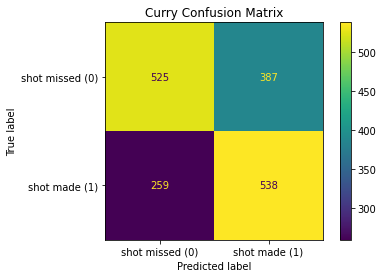

In [197]:
'''T9. Calculate precision and recall'''

instructor_precision = 538 /(538 + 387)
instructor_recall = 538 /(538 + 259)

print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [198]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. 

This task will not be autograded - but it is part of completing the challenge.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


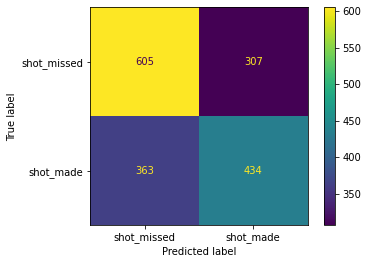

In [199]:
'''T10. Plot ROC curve.'''
plot_confusion_matrix(
    model,
    X_test,
    y_test,
    values_format='.0f',
    display_labels=['shot_missed', 'shot_made']
)

In [200]:
my_precision = 433 /(433 + 301)
my_recall = 433 /(433 + 364)

print('Instuctor model precision', my_precision)
print('Instuctor model recall', my_recall)

Instuctor model precision 0.5899182561307902
Instuctor model recall 0.5432873274780426
